In [3]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv, norm, svd, matrix_rank
from Helpers import *
import math
import time

In [4]:
def ImageRepresentation(data, sampled_data, reconstructed_data, colormap='cubehelix'):
    # Create a colormap and set NaN values to be transparent (or red if preferred)
    cmap = plt.get_cmap(colormap).copy()
    cmap.set_bad(color='none')  # Use 'none' for transparency or 'red' for red color
    
    colormaps = [cmap]*3 
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 10))  # Create a figure with 1 row and 3 columns
    
    # Plot each matrix with its respective colormap
    for ax, matrix, cmap, title in zip(axes, [data, sampled_data, reconstructed_data], colormaps, ['Original Data', 'Sampled Data', 'Reconstructed Data']):
        cax = ax.imshow(matrix, aspect='auto', cmap=cmap)
        ax.set_title(f'{title} Colormap')
        fig.colorbar(cax, ax=ax)
        
    # Add overall title and show the plot
    fig.suptitle(f'Side by Side comparison of Data, Sampled Data and Reconstruction', fontsize=16)
    plt.show()

def relative_approx_error(original, approximation):
    """
    Calculate the relative approximation error between the original and approximation matrices.
    """
    error = norm(original - approximation, 'fro')
    fro_M = norm(original, 'fro')
    rel_error = 100 * (error / fro_M) ** 2
    print(f'relative error = {rel_error}%')
    return rel_error

def soft_thresholding(U, Sigma, VT, threshold):
    """
    Apply soft-thresholding to the singular values in the decomposition.
    """
    Sigma_thresholded = np.maximum(Sigma - threshold, 0)
    return (U * (Sigma_thresholded)) @ VT

def random_matrix_generation(num_rows, num_columns, rank):
    """
    Generate a random matrix of specified rank with values between 0 and 1.
    """
    A = np.random.normal(size=(num_rows, rank))
    B = np.random.normal(size=(rank, num_columns))
#     A= np.random.randn(num_rows, rank)
#     B= np.random.randn(rank, num_columns)
    M = A @ B
    return M


def projection_operator(M_sampled, X):
    """
    Compute the projection operator for matrix completion.
    """
    filled_M_sampled = np.where(M_sampled == 0, X, M_sampled)
    projection = X - filled_M_sampled
    return projection

def suggested_stop(X_k, original_sampled, tolerance):
    """
    Check the stopping condition based on the relative difference between X_k and the original sampled matrix.
    """
    rel_error = norm(projection_operator(original_sampled, X_k), 'fro') / norm(original_sampled, 'fro')
    print("Current relative in-sampling error:", rel_error)
    return rel_error <= tolerance

def k_0_finder(tau, step_size, sampled_entries):
    """
    Find the initial value of k_0.
    """
    return math.ceil(tau / (step_size * norm(sampled_entries, 2)))


def plot_metrics(em,r):
    """
    Plot error history and rank history over iterations.
    """
    fig, ax1 = plt.subplots()

    # Plot error history
    color = 'tab:red'
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Relative in-sampling error', color=color)
    ax1.plot(range(len(em)), em, color=color, label='Relative in-sampling error')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_yscale('log')


    # Instantiate a second axes that shares the same x-axis
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Rank of X', color=color)
    ax2.plot(range(len(r)), r, color=color, label='Rank of X')
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # Adjust layout to avoid overlap
    plt.title('Error and Rank Convergence Over Iterations')
    ax1.legend(loc='upper left')  # Add legend for error plots
    ax2.legend(loc='upper right')  # Add legend for rank plot
    plt.show()



In [5]:

# Parameters for matrix generation
n = 1000    # Matrix dimensions
r = 10      # Rank
m = 120000  # Cardinality
p = m/(n*n)

# Generate a random low-rank matrix
M= random_matrix_generation(n,n,r)

# Calculate matrix characteristics
M_nuc = norm(M, 'nuc')
M_fro = norm(M, 'fro')
M_rank = matrix_rank(M)
M_shape = M.shape
print(p)

# Parameters for Singular Value Thresholding (SVT)
step_size = 1.2/p
tolerance = 1e-7

0.12


In [6]:
M_sampled, coords, coords_TF, M_sampled_nans = sample_from_matrix_ratio(M,ratio_to_keep=p, seed=42)

In [7]:

def svt_algorithm(sampled_entries, step_size, tolerance, tau, max_iter=117):
    """
    Singular Value Thresholding (SVT) algorithm for matrix completion.
    """
    k = 1
    Y_0 = k_0_finder(tau, step_size, sampled_entries) * step_size * sampled_entries
    u, s, v = svd(Y_0, full_matrices=False)
    print(s[0])
    
    iterate = True
    em_sampled_arr = []
    rank_arr = []
    in_sampling_err_list = []


    while iterate:
        if k == 1:
            Y = Y_0

        # Singular Value Decomposition
        U, sigma, Vt = svd(Y, full_matrices=False)
        # Thresholding
        sigma_thresh = np.maximum(sigma - tau, 0)
        # Check for rank stopping condition
        rank = np.sum(sigma_thresh > 0)
        # Construct the approximation matrix X
        X = U[:, :rank] * sigma_thresh[:rank] @ Vt[:rank, :]

        # Calculate errors
        
        # CHECK
        error_sampled_matrix = -projection_operator(M_sampled=sampled_entries, X=X)
        in_sampling_error = (norm(projection_operator(sampled_entries, X=X), 'fro') / norm(sampled_entries, 'fro')) 

        # Update Y
        Y = Y + step_size * error_sampled_matrix

        k += 1
        print(k, norm(error_sampled_matrix, 'fro'))
        print(f'rank is {rank} \n')
        # Append results for plotting
        rank_arr.append(rank)
        em_sampled_arr.append(norm(error_sampled_matrix, 'fro'))
        in_sampling_err_list.append(in_sampling_error)

        # Check stopping conditions
        if suggested_stop(X, sampled_entries, tolerance):
            iterate = False
            print("SUGGESTED STOP")
            
        if k >= max_iter:
            print("MAX ITER STOP")
            iterate = False

    return X, em_sampled_arr, rank_arr, in_sampling_err_list


In [8]:
start_time = time.time()
# Run the SVT algorithm
X_opt, em_sampled_arr, rank_arr, in_sampling_err_list = svt_algorithm(M_sampled, step_size, tolerance, tau=5*(n), max_iter=118)

run_time = time.time() - start_time
print('Total runtime:',run_time)

5807.332080309141
2 795.5988774293169
rank is 7 

Current relative in-sampling error: 0.7262765148904843
3 522.4641242266546
rank is 10 

Current relative in-sampling error: 0.4769406217926136
4 357.34606128955903
rank is 10 

Current relative in-sampling error: 0.32620967596360123
5 260.89788375464906
rank is 10 

Current relative in-sampling error: 0.23816525026766833
6 206.61141663418553
rank is 10 

Current relative in-sampling error: 0.1886088880548899
7 172.07419795502113
rank is 10 

Current relative in-sampling error: 0.15708097678211094
8 147.57917686749585
rank is 10 

Current relative in-sampling error: 0.1347202632965677
9 128.3385752477758
rank is 10 

Current relative in-sampling error: 0.1171561396091157
10 112.68062354139133
rank is 10 

Current relative in-sampling error: 0.10286250129682843
11 99.63462425566314
rank is 10 

Current relative in-sampling error: 0.09095322997518282
12 88.63311869020096
rank is 10 

Current relative in-sampling error: 0.08091031092727101


In [8]:
general_error_relative(M, X_opt)

0.00015419399582711728

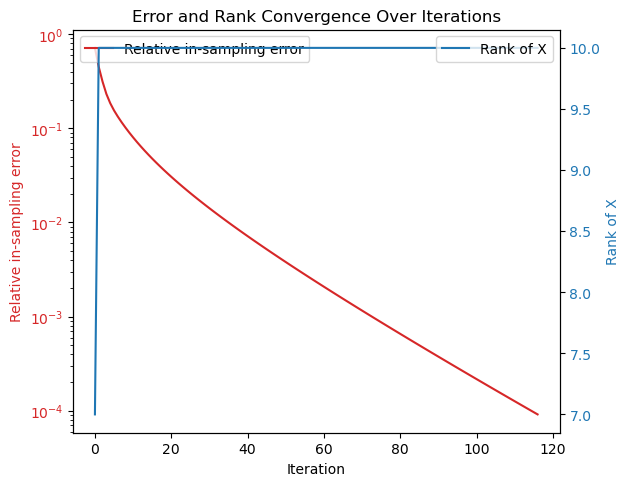

In [9]:
plot_metrics(in_sampling_err_list, rank_arr)

In [9]:

# Parameters for matrix generation
n = 1000    # Matrix dimensions
r = 50      # Rank
m = .39*n*n  # Cardinality
p = m/(n*n)

# Generate a random low-rank matrix
M= random_matrix_generation(n,n,r)

# Calculate matrix characteristics
M_nuc = norm(M, 'nuc')
M_fro = norm(M, 'fro')
M_rank = matrix_rank(M)
M_shape = M.shape
print(p)

# Parameters for Singular Value Thresholding (SVT)
step_size = 1.2/p
tolerance = 1e-7

0.39


In [10]:
M_sampled, coords, coords_TF, M_sampled_nans = sample_from_matrix_ratio(M,ratio_to_keep=p, seed=42)

In [ ]:
start_time = time.time()
# Run the SVT algorithm
X_opt, em_sampled_arr, rank_arr, in_sampling_err_list = svt_algorithm(M_sampled, step_size, tolerance, tau=5*(n), max_iter=114)

run_time = time.time() - start_time
print('Total runtime:',run_time)

6626.935174281138
2 3056.961021233627
rank is 27 

Current relative in-sampling error: 0.6889476933460604
3 1812.9221224976836
rank is 46 

Current relative in-sampling error: 0.40857848884405784
4 1144.8342043457546
rank is 50 

Current relative in-sampling error: 0.25801142993618875
5 940.1979157249976
rank is 50 

Current relative in-sampling error: 0.21189252359721436
6 800.3130108761334
rank is 50 

Current relative in-sampling error: 0.1803666448371813
7 689.2382599636804
rank is 50 

Current relative in-sampling error: 0.1553337141263928
8 598.8159732619746
rank is 50 

Current relative in-sampling error: 0.13495523189599884
9 524.1238564748612
rank is 50 

Current relative in-sampling error: 0.11812186005573566
10 461.78549189084384
rank is 50 

Current relative in-sampling error: 0.10407265491742708
11 409.2131690734655
rank is 50 

Current relative in-sampling error: 0.09222442385157563
12 364.4745632320955
rank is 50 

Current relative in-sampling error: 0.08214167857486544


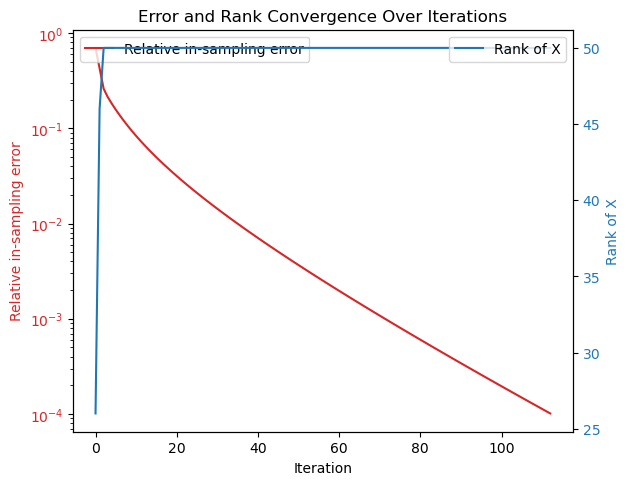

In [167]:
plot_metrics(in_sampling_err_list, rank_arr)

In [169]:

# Parameters for matrix generation
n = 1000    # Matrix dimensions
r = 100      # Rank
m = .57*n*n  # Cardinality
p = m/(n*n)

# Generate a random low-rank matrix
M= random_matrix_generation(n,n,r)

# Calculate matrix characteristics
M_nuc = norm(M, 'nuc')
M_fro = norm(M, 'fro')
M_rank = matrix_rank(M)
M_shape = M.shape
print(p)

# Parameters for Singular Value Thresholding (SVT)
step_size = 1.2/p
tolerance = 1e-7

0.57


In [170]:
M_sampled, coords, coords_TF, M_sampled_nans = sample_from_matrix_ratio(M,ratio_to_keep=p, seed=42)

In [171]:
start_time = time.time()
# Run the SVT algorithm
X_opt, em_sampled_arr, rank_arr, in_sampling_err_list = svt_algorithm(M_sampled, step_size, tolerance, tau=5*(n), max_iter=129)

run_time = time.time() - start_time
print('Total runtime:',run_time)

5442.997187268785
2 7397.905267714553
Current relative in-sampling error: 0.9812493335319991
3 5074.343268676663
Current relative in-sampling error: 0.6730548405683752
4 3327.7697334522272
Current relative in-sampling error: 0.4413914094505204
5 2195.04483245213
Current relative in-sampling error: 0.29114812923008876
6 1586.1859926901234
Current relative in-sampling error: 0.21038981872037552
7 1329.6628308211575
Current relative in-sampling error: 0.1763648924053612
8 1158.8095273951851
Current relative in-sampling error: 0.15370311396246583
9 1019.5857468748192
Current relative in-sampling error: 0.1352366377230886
10 902.9059134926956
Current relative in-sampling error: 0.11976036375098303
11 804.1561194514876
Current relative in-sampling error: 0.10666230881748259
12 719.8609480875751
Current relative in-sampling error: 0.09548149780037181
13 647.3505523458399
Current relative in-sampling error: 0.0858638053697549
14 584.5228858134715
Current relative in-sampling error: 0.077530418

107 2.2281168531409667
Current relative in-sampling error: 0.0002955347626195567
108 2.120991495156438
Current relative in-sampling error: 0.00028132578287154094
109 2.019154829916153
Current relative in-sampling error: 0.0002678182890229448
110 1.9223368000113943
Current relative in-sampling error: 0.00025497646098108953
111 1.830281743435353
Current relative in-sampling error: 0.0002427663880422404
112 1.7427475836101713
Current relative in-sampling error: 0.00023115596145775969
113 1.6595050681093757
Current relative in-sampling error: 0.0002201147734591579
114 1.5803370529073701
Current relative in-sampling error: 0.00020961402232180006
115 1.505037829221878
Current relative in-sampling error: 0.0001996264230780898
116 1.433412490210848
Current relative in-sampling error: 0.0001901261235169021
117 1.3652763349867758
Current relative in-sampling error: 0.00018108862513275363
118 1.3004543075761983
Current relative in-sampling error: 0.00017249070871005898
119 1.2387804686280885
Curr

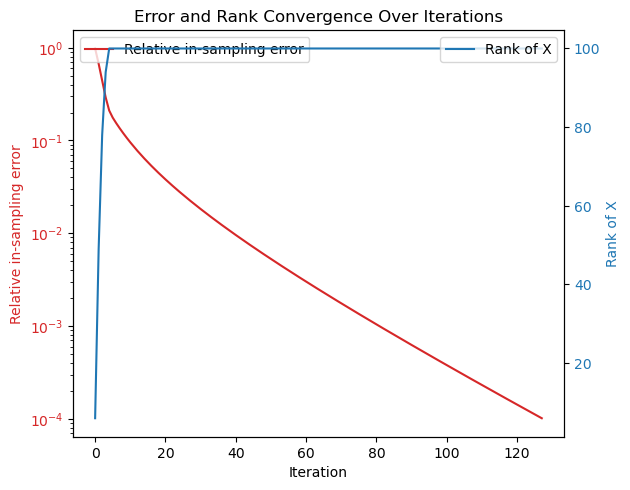

In [172]:
plot_metrics(in_sampling_err_list, rank_arr)